In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

df_prescribers = pd.read_csv("pa2017.csv", dtype={'NPI': str})  # 1 row per dr
df_drugs = pd.read_csv("padrugs2017.csv", dtype={'NPI': str})  # 1 row per dr/drug
df_opioids = pd.read_csv("druggeographypa.csv", dtype={'Gnrc_Name': str})  # classify

df_drugs = df_drugs.merge(df_opioids, on="Gnrc_Name", how="left")  # Add opioid classification to drug data
df_opioids_only = df_drugs[df_drugs["Opioid_Drug_Flag"] == 'Y']  # Keep only opioid drugs

In [2]:
codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")
print(codes.columns)
df_opioids = codes[codes["pharmclas"].str.contains("opioid agonist", case=False, na=False)]
opioid_ndcs = df_opioids[["ndc"]].drop_duplicates()
opioid_ndcs.to_csv("opioid_ndcs.csv", index=False)
print("Opioid NDCs extracted and saved as 'opioid_ndcs.csv'")

Index(['prodid', 'ndc', 'prodtype', 'propname', 'propsuf', 'npropname',
       'dosename', 'routename', 'stmarkdatestr', 'stmarkdate',
       'endmarkdatestr', 'endmarkdate', 'markname', 'appnum', 'labelname',
       'subname', 'actnumstr', 'actingunit', 'pharmclas', 'deasched',
       'ndc_exclude_flag', 'listing_record_certstr', 'listing_record_cert'],
      dtype='object')
Opioid NDCs extracted and saved as 'opioid_ndcs.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712877063.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")


In [3]:
df_opioids_agg = df_opioids_only.groupby("Prscrbr_NPI").agg(
    Total_Opioid_Claims=("Tot_Clms_x", "sum"),  # Total opioid prescriptions per doctor
    Unique_Opioid_Drugs=("Gnrc_Name", "nunique")  # Number of distinct opioids prescribed
).reset_index()

df_merged = pd.merge(df_prescribers, df_opioids_agg, on="Prscrbr_NPI", how="left")
df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
df_merged["Unique_Opioid_Drugs"].fillna(0, inplace=True)

df_specialty_stats = df_merged.groupby("Prscrbr_Type")["Total_Opioid_Claims"].agg(['mean', 'std']).reset_index()
df_specialty_stats.rename(columns={'mean': 'Specialty_Mean_Opioid_Claims', 'std': 'Specialty_Std_Opioid_Claims'}, inplace=True)

df_merged = pd.merge(df_merged, df_specialty_stats, on="Prscrbr_Type", how="left")

df_merged["Opioid_Prescribing_ZScore"] = (df_merged["Total_Opioid_Claims"] - df_merged["Specialty_Mean_Opioid_Claims"]) / df_merged["Specialty_Std_Opioid_Claims"]
df_merged.to_csv("pa_merged_opioid_specialty_adjusted.csv", index=False)


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [4]:
df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str}) 
df_opioid_ndcs = pd.read_csv("opioid_ndcs.csv", dtype=str)
opioid_ndc_set = set(df_opioid_ndcs["ndc"].astype(str).str.strip())
def is_opioid_payment(row):
    for i in range(1, 6):  
        ndc = str(row.get(f"Associated_Drug_or_Biological_NDC_{i}", "")) 
        if any(opioid_ndc in ndc for opioid_ndc in opioid_ndc_set):  
            return True
    return False
df_payments["Is_Opioid_Payment"] = df_payments.apply(is_opioid_payment, axis=1)
df_opioid_payments = df_payments[df_payments["Is_Opioid_Payment"]]
df_opioid_payments.to_csv("opioid_payments_filtered.csv", index=False)
print("Filtered Open Payments data saved as 'opioid_payments_filtered.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2791430706.py:1: DtypeWarning: Columns (4,10,15,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str})


Filtered Open Payments data saved as 'opioid_payments_filtered.csv'


In [31]:
df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})
df_network = df_opioid_payments.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Covered_Recipient_NPI"]).agg(
    Total_Opioid_Payments=("Total_Amount_of_Payment_USDollars", "sum")
).reset_index()
df_network.to_csv("pharma_prescriber_network_data.csv", index=False)
print("Aggregated network data saved as 'pharma_prescriber_network_data.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/171572685.py:1: DtypeWarning: Columns (4,35,51,54,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})


Aggregated network data saved as 'pharma_prescriber_network_data.csv'


In [32]:
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={'covered_recipient_NPI': str})
G = nx.DiGraph()
pharma_nodes = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
prescriber_nodes = df_network["Covered_Recipient_NPI"].unique()
G.add_nodes_from(pharma_nodes, bipartite=0)  # Group 0: Pharma companies
G.add_nodes_from(prescriber_nodes, bipartite=1)  # Group 1: Prescribers
for _, row in df_network.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], 
               row["Covered_Recipient_NPI"], 
               weight=row["Total_Opioid_Payments"])
nx.write_gml(G, "pharma_prescriber_network.gml")
print("Network constructed and saved as 'pharma_prescriber_network.gml'")

Network constructed and saved as 'pharma_prescriber_network.gml'


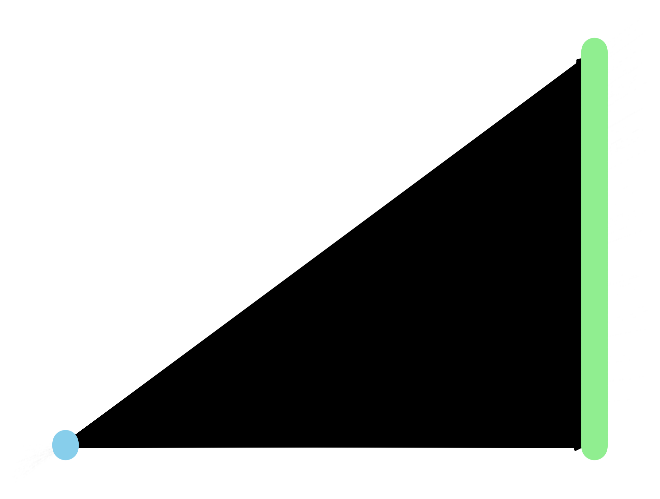

Total pharmaceutical companies: 24
Total doctors: 2026


In [33]:
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

left_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
right_nodes = set(G) - left_nodes
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(left_nodes))
pos.update((n, (2, i)) for i, n in enumerate(right_nodes))
nx.draw(G, pos, with_labels=False, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()])
plt.show()

pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}

print(f"Total pharmaceutical companies: {len(pharma_nodes)}")
print(f"Total doctors: {len(doctor_nodes)}")

In [8]:
pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
centrality = bipartite.degree_centrality(G, pharma_nodes)
pharma_centrality = {n: c for n, c in centrality.items() if n in pharma_nodes}
for node, centrality_score in pharma_centrality.items():
    print(f"{node}: {centrality_score:.4f}")
unweighted_degree = dict(G.degree(pharma_nodes))
for node in pharma_nodes:
    print(f"{node}: {unweighted_degree[node]:,.2f}")

Mallinckrodt LLC: 0.0010
INSYS Therapeutics Inc: 0.0997
The Medicines Company: 0.0138
Daiichi Sankyo Inc.: 0.1037
Collegium Pharmaceutical, Inc.: 0.1422
BioDelivery Sciences International, Inc.: 0.0647
Mylan Institutional Inc.: 0.0039
Egalet US Inc: 0.0582
Purdue Pharma L.P.: 0.4768
Akrimax Pharmaceuticals, LLC: 0.0064
Pernix Therapeutics Holdings, Inc.: 0.1022
Purdue Transdermal Technologies L.P.: 0.0005
Endo Pharmaceuticals Inc.: 0.0015
PFIZER INC.: 0.0933
Mission Pharmacal Company: 0.0104
Indivior Inc.: 0.1624
Depomed, Inc.: 0.2878
Orexo US, Inc.: 0.0582
Mylan Specialty L.P.: 0.0227
Braeburn Pharmaceuticals, Inc.: 0.0395
Vertical Pharmaceuticals, LLC: 0.0370
Fresenius Kabi USA, LLC: 0.0005
Mylan Pharmaceuticals Inc.: 0.0123
Sentynl Therapeutics, Inc.: 0.0311
Mallinckrodt LLC: 2.00
The Medicines Company: 28.00
Daiichi Sankyo Inc.: 210.00
Collegium Pharmaceutical, Inc.: 288.00
Pernix Therapeutics Holdings, Inc.: 207.00
Purdue Transdermal Technologies L.P.: 1.00
Endo Pharmaceuticals In

In [20]:
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
centrality = bipartite.degree_centrality(G, doctor_nodes)
doctor_centrality = {n: c for n, c in centrality.items() if n in doctor_nodes}
df = pd.DataFrame.from_dict(doctor_centrality, orient='index', columns=['degree_centrality'])
df.index.name = 'doctor_id' 
df.to_csv("doctor_degree_centrality.csv")

In [21]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
pharma_hubs = {n: h for n, h in hubs.items() if G.nodes[n].get("bipartite") == 0}
doctor_authorities = {n: a for n, a in authorities.items() if G.nodes[n].get("bipartite") == 1}
pharma_df = pd.DataFrame.from_dict(pharma_hubs, orient='index', columns=['hub_score'])
pharma_df.index.name = 'pharma_company'
pharma_df.to_csv("pharma_hub_scores.csv")
doctor_df = pd.DataFrame.from_dict(doctor_authorities, orient='index', columns=['authority_score'])
doctor_df.index.name = 'doctor_id'
doctor_df.to_csv("doctor_authority_scores.csv")

In [ ]:
import os
import pyproj
os.environ["PROJ_DATA"] = "/opt/homebrew/share/proj"
pyproj.datadir.set_data_dir(os.environ["PROJ_DATA"])

df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})
df_zips["Recipient_Zip_Code"] = df_zips["Recipient_Zip_Code"].str[:5].str.zfill(5)
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
doctor_ids_in_G = {
    str(n).split(".")[0].strip().zfill(10)
    for n, d in G.nodes(data=True)
    if d.get("bipartite") == 1
}



/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2937704651.py:6: DtypeWarning: Columns (4,10,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})


Overlap count: 3385


In [40]:
# Clean up NPI and ZIP fields
df_payments["Covered_Recipient_NPI"] = (
    df_payments["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)

df_payments["Recipient_Zip_Code"] = (
    df_payments["Recipient_Zip_Code"]
    .astype(str)
    .str.strip()
    .str[:5]
    .str.zfill(5)
)

# Filter and extract ZIPs
df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()

# Rename columns
df_zips = df_zips.rename(columns={
    "Covered_Recipient_NPI": "doctor_id",
    "Recipient_Zip_Code": "zip"
})

# Sanity check
print("✅ Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (3385, 2)
Sample matched ZIPs: ['19030' '19115' '18344' '17403' '17112']


In [38]:
df_payments["Covered_Recipient_NPI"] = df_payments["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_payments["Recipient_Zip_Code"] = df_payments["Recipient_Zip_Code"].astype(str).str[:5].str.zfill(5)

df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
df_zips = df_zips.rename(columns={"Covered_Recipient_NPI": "doctor_id", "Recipient_Zip_Code": "zip"})

print("✅ Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (0, 2)
Sample matched ZIPs: []


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


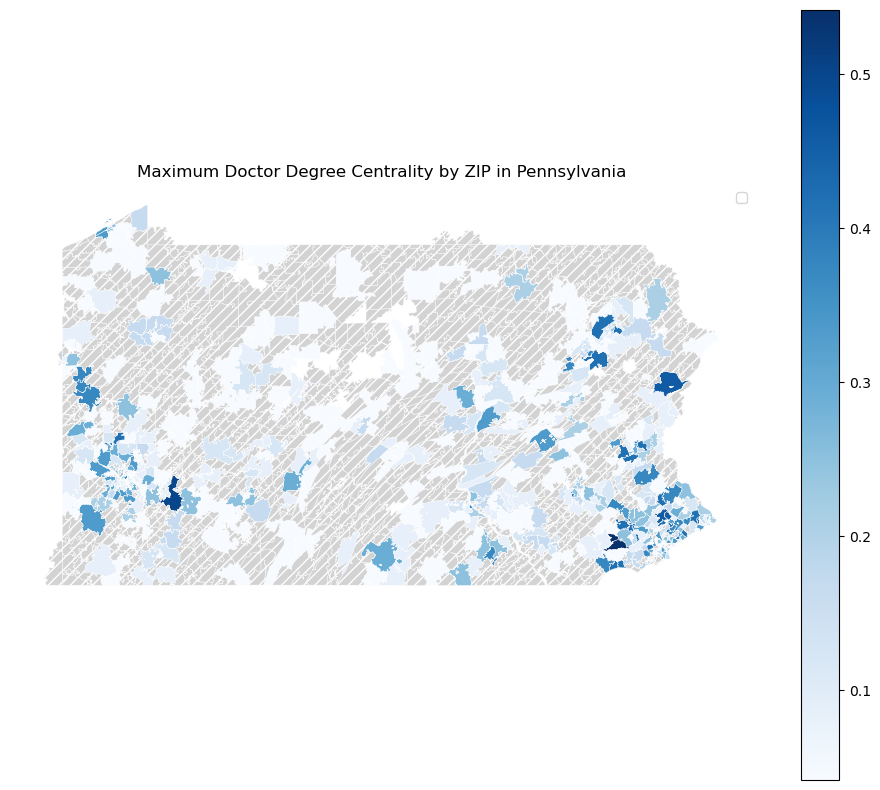

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load ZIP shapefile
zip_shapes = gpd.read_file("pa_zip_shapefile.shp")
zip_shapes = zip_shapes.rename(columns={"ZCTA5CE": "zip"})
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)

# Load centrality scores
df_centrality = pd.read_csv("doctor_degree_centrality.csv", dtype=str)
df_centrality["doctor_id"] = df_centrality["doctor_id"].str.split(".").str[0].str.zfill(10)

# Merge with ZIP data (assuming df_zips is already created & cleaned)
df_joined = pd.merge(df_centrality, df_zips, on="doctor_id", how="inner")
df_joined["degree_centrality"] = df_joined["degree_centrality"].astype(float)

# Use MAX instead of average
df_by_zip = df_joined.groupby("zip").agg(
    max_centrality=("degree_centrality", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()

# Merge with spatial shapes
df_by_zip["zip"] = df_by_zip["zip"].astype(str).str.zfill(5)
merged = zip_shapes.merge(df_by_zip, on="zip", how="left")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

merged.plot(
    column="max_centrality",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Degree Centrality by ZIP in Pennsylvania")
plt.axis("off")
plt.legend()
fig.savefig("doctor_degree_centrality_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()



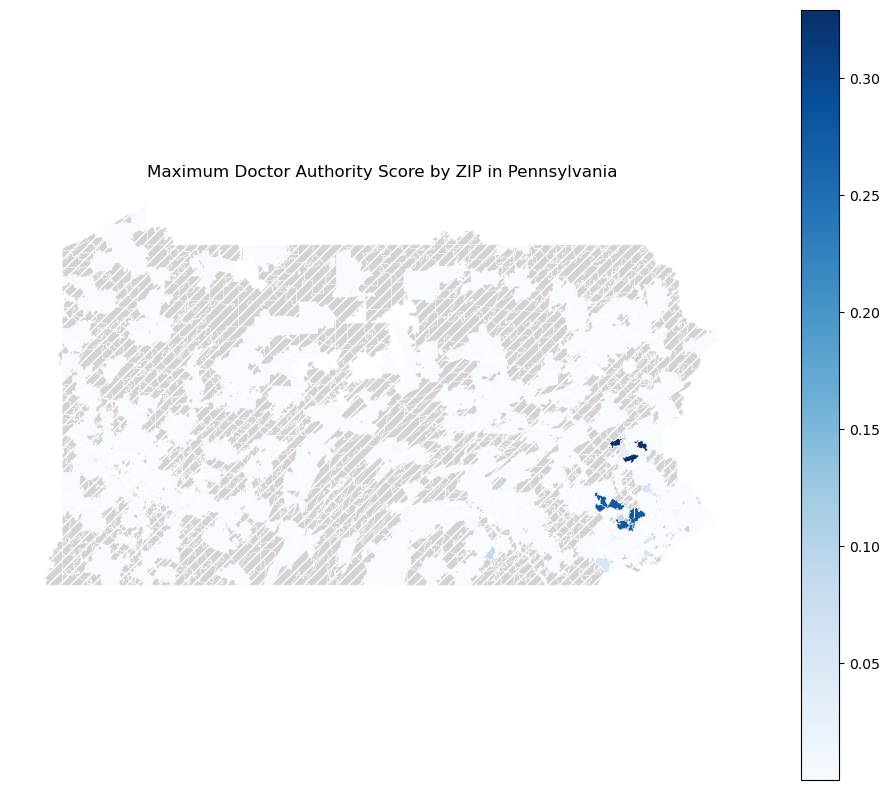

In [42]:

df_authority = pd.read_csv("doctor_authority_scores.csv", dtype={"doctor_id": str})
df_authority["doctor_id"] = df_authority["doctor_id"].str.split(".").str[0].str.zfill(10)
df_authority["authority_score"] = df_authority["authority_score"].astype(float)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)
df_joined_auth = pd.merge(df_authority, df_zips, on="doctor_id", how="inner")
df_by_zip_auth = df_joined_auth.groupby("zip").agg(
    max_authority=("authority_score", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_by_zip_auth["zip"] = df_by_zip_auth["zip"].astype(str).str.zfill(5)
merged_auth = zip_shapes.merge(df_by_zip_auth, on="zip", how="left")
fig, ax = plt.subplots(figsize=(12, 10))
merged_auth.plot(
    column="max_authority",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Authority Score by ZIP in Pennsylvania")
plt.axis("off")

fig.savefig("doctor_simple_authority_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()




In [43]:

top_zip_max_auth = df_by_zip_auth.sort_values("max_authority", ascending=False)
print(top_zip_max_auth[["zip", "max_authority", "doctor_count"]].head())

       zip  max_authority  doctor_count
348  18017       0.329150            22
365  18078       0.329150             1
368  18103       0.329150            29
582  19460       0.276301            21
593  19518       0.276301             1


In [44]:
import pandas as pd

max_auth_idx = df_joined_auth.groupby("zip")["authority_score"].idxmax()
top_doctors_by_zip = df_joined_auth.loc[max_auth_idx, ["zip", "doctor_id", "authority_score"]]
top_doctors_by_zip = top_doctors_by_zip.sort_values("authority_score", ascending=False)
df_names = pd.read_csv("generalpaymentspa.csv", dtype=str)
df_names["Covered_Recipient_NPI"] = df_names["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
top_doctors_by_zip["doctor_id"] = top_doctors_by_zip["doctor_id"].astype(str).str.strip().str.zfill(10)
top_doctors_named = pd.merge(
    top_doctors_by_zip,
    df_names[["Covered_Recipient_NPI", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]],
    left_on="doctor_id",
    right_on="Covered_Recipient_NPI",
    how="left"
).drop_duplicates(subset=["doctor_id", "zip"])
top_doctors_named = top_doctors_named[["zip", "doctor_id", "authority_score", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]]
top_doctors_named = top_doctors_named.sort_values("authority_score", ascending=False)
top_doctors_named.to_csv("top_authority_doctors_by_zip.csv", index=False)


In [45]:
from scipy.sparse.linalg import svds

df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
companies = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
doctors = df_network["Covered_Recipient_NPI"].unique()
company_to_idx = {name: i for i, name in enumerate(companies)}
doctor_to_idx = {npi: j for j, npi in enumerate(doctors)}
W = np.zeros((len(companies), len(doctors)))
for _, row in df_network.iterrows():
    i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
    j = doctor_to_idx[row["Covered_Recipient_NPI"]]
    W[i, j] = row["Total_Opioid_Payments"]
Dx = np.diag(W.sum(axis=1))
Dy = np.diag(W.sum(axis=0))
Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt
u, s, vt = svds(W_hat, k=2)
x_hat = u[:, -1]  
y_hat = vt.T[:, -1] 
x = Dx_inv_sqrt @ x_hat
y = Dy_inv_sqrt @ y_hat
cx = np.median(x)
cy = np.median(y)
A = [companies[i] for i in range(len(x)) if x[i] >= cx]
Ac = [companies[i] for i in range(len(x)) if x[i] < cx]
B = [doctors[j] for j in range(len(y)) if y[j] >= cy]
Bc = [doctors[j] for j in range(len(y)) if y[j] < cy]

print("Partition A (pharma):", A[:5])
print("Partition B (doctors):", B[:5])

Partition A (pharma): ['Akrimax Pharmaceuticals, LLC', 'BioDelivery Sciences International, Inc.', 'Daiichi Sankyo Inc.', 'Egalet US Inc', 'INSYS Therapeutics Inc']
Partition B (doctors): ['1194731547.0', '1275505919.0', '1316042591.0', '1336159508.0', '1578561023.0']


In [46]:
partition_A_indices = np.where(x >= cx)[0]
partition_Ac_indices = np.where(x < cx)[0]
partition_A_companies = [companies[i] for i in partition_A_indices]
partition_Ac_companies = [companies[i] for i in partition_Ac_indices]
print("Number of pharma companies in Partition A:", len(partition_A_companies))
print("Number of pharma companies in Partition Aᶜ:", len(partition_Ac_companies))
print("\nPartition A Companies:")
print(partition_A_companies)
print("\nPartition Aᶜ Companies:")
print(partition_Ac_companies)

Number of pharma companies in Partition A: 12
Number of pharma companies in Partition Aᶜ: 12

Partition A Companies:
['Akrimax Pharmaceuticals, LLC', 'BioDelivery Sciences International, Inc.', 'Daiichi Sankyo Inc.', 'Egalet US Inc', 'INSYS Therapeutics Inc', 'Mallinckrodt LLC', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'PFIZER INC.', 'Purdue Transdermal Technologies L.P.', 'The Medicines Company', 'Vertical Pharmaceuticals, LLC']

Partition Aᶜ Companies:
['Braeburn Pharmaceuticals, Inc.', 'Collegium Pharmaceutical, Inc.', 'Depomed, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'Indivior Inc.', 'Mission Pharmacal Company', 'Mylan Institutional Inc.', 'Orexo US, Inc.', 'Pernix Therapeutics Holdings, Inc.', 'Purdue Pharma L.P.', 'Sentynl Therapeutics, Inc.']


In [47]:
import numpy as np
import pandas as pd

cy = np.median(y)
partition_B_indices = np.where(y >= cy)[0]
partition_B_doctors = [doctors[j] for j in partition_B_indices]
partition_Bc_indices = np.where(y < cy)[0]
partition_Bc_doctors = [doctors[j] for j in partition_Bc_indices]
print("Number in Partition B:", len(partition_B_doctors))
print("Number in Partition Bᶜ:", len(partition_Bc_doctors))
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
df_partition_B = df_network[df_network["Covered_Recipient_NPI"].isin(partition_B_doctors)]
payments_summary = df_partition_B.groupby("Covered_Recipient_NPI").agg(
    Total_Received=("Total_Opioid_Payments", "sum"),
    Num_Companies=("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "nunique")
).reset_index()
print(payments_summary.head())

Number in Partition B: 1048
Number in Partition Bᶜ: 978
  Covered_Recipient_NPI  Total_Received  Num_Companies
0          1003022500.0          169.20              3
1          1003120213.0          221.76              2
2          1003143280.0           28.53              1
3          1003171141.0           12.75              1
4          1003296245.0           12.22              1


In [49]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

# Step 1: Load and normalize
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})

df_network["Company_Total"] = df_network.groupby(
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"
)["Total_Opioid_Payments"].transform("sum")

df_network["Normalized_Weight"] = (
    df_network["Total_Opioid_Payments"] / df_network["Company_Total"]
)

# Step 2: Recursive function
def recursive_partition(df_network, min_group_size=6):
    partitions = [{"name": "root", "companies": df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()}]
    final = []

    while partitions:
        part = partitions.pop(0)
        companies = part["companies"]
        if len(companies) <= min_group_size:
            final.append(part)
            continue

        sub_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(companies)]
        doctors = sub_df["Covered_Recipient_NPI"].unique()

        company_to_idx = {c: i for i, c in enumerate(companies)}
        doctor_to_idx = {d: j for j, d in enumerate(doctors)}

        W = np.zeros((len(companies), len(doctors)))
        for _, row in sub_df.iterrows():
            i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
            j = doctor_to_idx[row["Covered_Recipient_NPI"]]
            W[i, j] = row["Normalized_Weight"]

        Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
        Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
        W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt

        u, s, vt = svds(W_hat, k=2)
        x_hat = u[:, -1]
        x = Dx_inv_sqrt @ x_hat
        cx = np.median(x)

        A = [companies[i] for i in range(len(x)) if x[i] >= cx]
        Ac = [companies[i] for i in range(len(x)) if x[i] < cx]

        partitions.append({"name": part["name"] + "_A", "companies": A})
        partitions.append({"name": part["name"] + "_Ac", "companies": Ac})

    return final

# Step 3: Run the recursive partitioning
final_partitions = recursive_partition(df_network, min_group_size=6)

# Step 4: Display results
for p in final_partitions:
    print(f"📦 Partition '{p['name']}' — {len(p['companies'])} companies")
    print(p["companies"])
    print()



📦 Partition 'root_A_A' — 6 companies
['Akrimax Pharmaceuticals, LLC', 'Braeburn Pharmaceuticals, Inc.', 'Egalet US Inc', 'Mallinckrodt LLC', 'PFIZER INC.', 'Purdue Transdermal Technologies L.P.']

📦 Partition 'root_A_Ac' — 6 companies
['Indivior Inc.', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'Orexo US, Inc.', 'Purdue Pharma L.P.', 'Vertical Pharmaceuticals, LLC']

📦 Partition 'root_Ac_A' — 6 companies
['BioDelivery Sciences International, Inc.', 'Collegium Pharmaceutical, Inc.', 'Depomed, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'Pernix Therapeutics Holdings, Inc.']

📦 Partition 'root_Ac_Ac' — 6 companies
['Daiichi Sankyo Inc.', 'INSYS Therapeutics Inc', 'Mission Pharmacal Company', 'Mylan Institutional Inc.', 'Sentynl Therapeutics, Inc.', 'The Medicines Company']



In [54]:
# Step 1: Build company → cluster mapping
company_to_cluster = {}
for partition in final_partitions:
    for company in partition["companies"]:
        company_to_cluster[company] = partition["name"]

# Step 2: Assign cluster labels to each payment record
df_network["cluster"] = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)
df_network = df_network.dropna(subset=["cluster"])

# Step 3: Standardize NPIs
df_network["Covered_Recipient_NPI"] = (
    df_network["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)



# Step 4: Merge ZIP code info into payment data
df_merged = df_network.merge(df_zips, left_on="Covered_Recipient_NPI", right_on="doctor_id", how="left")

# Step 5: Group by ZIP + cluster
df_zip_summary = (
    df_merged.groupby(["zip", "cluster"])["Covered_Recipient_NPI"]
    .nunique()
    .reset_index()
    .rename(columns={"Covered_Recipient_NPI": "doctor_count"})
)

# Step 6: Output or inspect
print(df_zip_summary.head())
# Optional: save
df_zip_summary.to_csv("doctors_by_zip_and_cluster.csv", index=False)



     zip    cluster  doctor_count
0  01510  root_A_Ac             1
1  01522  root_A_Ac             1
2  01801  root_A_Ac             1
3  01801  root_Ac_A             1
4  08002  root_A_Ac             1


In [55]:
# Pick the dominant pharma cluster per ZIP (most doctors)
df_zip_dominant = (
    df_zip_summary.sort_values(["zip", "doctor_count"], ascending=[True, False])
    .drop_duplicates(subset="zip")
)